### ДЗ к Уроку 7 . Кейс 2. Типы моделей для задачи тарификации

#### Построить обобщенную линейную модель (GLM) для прогнозирования наступления страховых случаев на рассмотренных в ноутбуке данных. Подобрать необходимое распределение и тип связи, при необходимости ознакомиться с документацией H20. Придумать и использовать дополнительные факторы при построении модели (например, пересечения признаков или функции от них и т.д.). Оценить результаты построенной модели при помощи различных метрик (можно использовать и другие метрики помимо представленных в ноутбуке), проанализировать вероятные проблемы. Предложить способы их решения и/или попробовать их решить, улучшив результат.

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split

import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.181-b13, mixed mode)
  Starting server from C:\Users\Larin-GV\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Larin-GV\AppData\Local\Temp\tmpgh6o0lxr
  JVM stdout: C:\Users\Larin-GV\AppData\Local\Temp\tmpgh6o0lxr\h2o_Larin_GV_started_from_python.out
  JVM stderr: C:\Users\Larin-GV\AppData\Local\Temp\tmpgh6o0lxr\h2o_Larin_GV_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,10 days
H2O_cluster_name:,H2O_from_python_Larin_GV_iw8z3w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.757 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [2]:
df = pd.read_csv('freMPL-R.csv', low_memory=False)

In [3]:
df.head()

,Exposure,LicAge,RecordBeg,RecordEnd,VehAge,Gender,MariStat,SocioCateg,VehUsage,DrivAge,...,ClaimInd,Dataset,DeducType,ClaimNbResp,ClaimNbNonResp,ClaimNbParking,ClaimNbFireTheft,ClaimNbWindscreen,OutUseNb,RiskArea
0,0.583,366,2004-06-01,NaN,2,Female,Other,CSP1,Professional,55,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.200,187,2004-10-19,NaN,0,Male,Alone,CSP55,Private+trip to office,34,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.083,169,2004-07-16,2004-08-16,1,Female,Other,CSP1,Professional,33,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.375,170,2004-08-16,NaN,1,Female,Other,CSP1,Professional,34,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.500,224,2004-01-01,2004-07-01,3,Male,Other,CSP47,Professional,53,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           115155 non-null  float64
 1   LicAge             115155 non-null  int64  
 2   RecordBeg          115155 non-null  object 
 3   RecordEnd          59455 non-null   object 
 4   Gender             115155 non-null  object 
 5   MariStat           115155 non-null  object 
 6   SocioCateg         115155 non-null  object 
 7   VehUsage           115155 non-null  object 
 8   DrivAge            115155 non-null  int64  
 9   HasKmLimit         115155 non-null  int64  
 10  BonusMalus         115155 non-null  int64  
 11  ClaimAmount        115155 non-null  float64
 12  ClaimInd           115155 non-null  int64  
 13  ClaimNbResp        115155 non-null  float64
 14  ClaimNbNonResp     115155 non-null  float64
 15  ClaimNbParking     115155 non-null  float64
 16  Cl

In [5]:
NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
NegClaimAmount.head()

Unique values of ClaimInd: [0]


,ClaimAmount,ClaimInd
82,-74.206042,0
175,-1222.585196,0
177,-316.288822,0
363,-666.758610,0
375,-1201.600604,0


In [6]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

In [7]:
def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [8]:
df.Gender, GenderRef = SeriesFactorizer(df.Gender)

{0: 'Male', 1: 'Female'}


In [9]:
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Other', 1: 'Alone'}


In [10]:
list(df.VehUsage.unique())

['Professional', 'Private+trip to office', 'Private', 'Professional run']

In [11]:
VU_dummies = pd.get_dummies(df.VehUsage, prefix='VehUsg', drop_first=False)
VU_dummies.head()

,VehUsg_Private,VehUsg_Private+trip to office,VehUsg_Professional,VehUsg_Professional run
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,1,0,0,0


In [12]:
df['SocioCateg'] = df.SocioCateg.str.slice(0,4)

In [13]:
pd.DataFrame(df.SocioCateg.value_counts().sort_values()).rename({'SocioCateg': 'Frequency'}, axis=1)

,Frequency
CSP7,14
CSP3,1210
CSP1,2740
CSP2,3254
CSP4,7648
CSP6,24833
CSP5,75456


In [14]:
df = pd.get_dummies(df, columns=['VehUsage','SocioCateg'])

In [15]:
df = df.select_dtypes(exclude=['object'])

In [16]:
df['DrivAgeSq'] = df.DrivAge.apply(lambda x: x**2)
df.head()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,ClaimNbResp,...,VehUsage_Professional,VehUsage_Professional run,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,DrivAgeSq
0,0.083,332,0,0,46,0,50,0.0,0,0.0,...,1,0,0,0,0,0,1,0,0,2116
1,0.916,333,0,0,46,0,50,0.0,0,0.0,...,1,0,0,0,0,0,1,0,0,2116
2,0.550,173,0,0,32,0,68,0.0,0,0.0,...,0,0,0,0,0,0,1,0,0,1024
3,0.089,364,1,0,52,0,50,0.0,0,0.0,...,0,0,0,0,0,0,1,0,0,2704
4,0.233,426,0,0,57,0,50,0.0,0,0.0,...,0,0,0,0,0,0,0,1,0,3249


In [17]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [18]:
pd.DataFrame(df.ClaimsCount.value_counts()).rename({'ClaimsCount': 'Policies'}, axis=1)

,Policies
0.0,104286
2.0,3529
1.0,3339
3.0,2310
4.0,1101
5.0,428
6.0,127
7.0,26
8.0,6
9.0,2


Preparing for modelling

In [19]:
# Разбиение датасета на train/val/test

x_train_ind, x_test_ind, y_train_ind, y_test_ind = train_test_split(df.drop(['ClaimInd', 'ClaimAmount', 'ClaimsCount'], axis=1), df.ClaimInd, test_size=0.3, random_state=1)
x_valid_ind, x_test_ind, y_valid_ind, y_test_ind = train_test_split(x_test_ind, y_test_ind, test_size=0.5, random_state=1)

In [20]:
# Преобразование в H2O-Frame

h2o_train = h2o.H2OFrame(pd.concat([x_train_ind, y_train_ind], axis=1))
h2o_valid = h2o.H2OFrame(pd.concat([x_valid_ind, y_valid_ind], axis=1))
h2o_test = h2o.H2OFrame(pd.concat([x_test_ind, y_test_ind], axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [21]:
# Преобразуем целевую переменную ClaimInd в категориальную при помощи метода asfactor во всех наборах данных

h2o_train['ClaimInd'] = h2o_train['ClaimInd'].asfactor()
h2o_valid['ClaimInd'] = h2o_valid['ClaimInd'].asfactor()
h2o_test['ClaimInd'] = h2o_test['ClaimInd'].asfactor()

In [22]:
# Инициализируем и обучим GLM модель c кросс-валидацией

glm_bin = H2OGeneralizedLinearEstimator(family='binomial', nfolds=5)

glm_bin.train(y='ClaimInd', 
              x=h2o_train.names[1:-1], 
              training_frame=h2o_train, 
              validation_frame=h2o_valid)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [23]:
# Параметры модели: распределение, функция связи, гиперпараметры регуляризации, количество использованных объясняющих переменных

glm_bin.summary()


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.5, lambda = 2.368E-5 )",20,20,3,py_1_sid_a31a


In [24]:
# Метрики качества модели - по всем данным и на кросс-валидации

glm_bin.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.5877963,0.07574172,0.6514734,0.6363409,0.5998365,0.5915073,0.45982307
1,auc,0.56292707,0.007780176,0.5669895,0.5558345,0.57341504,0.5548675,0.5635289
2,aucpr,0.11388518,0.004287366,0.11624542,0.1176835,0.115275346,0.106712006,0.11350962
3,err,0.41220376,0.07574172,0.34852663,0.3636591,0.40016347,0.40849268,0.5401769
4,err_count,6648.6,1254.7551,5689.0,5816.0,6365.0,6580.0,8793.0
5,f0point5,0.1365617,0.005191875,0.14021288,0.14143269,0.13927008,0.1305181,0.13137478
6,f1,0.18701366,0.0041805343,0.1874018,0.1890686,0.19092411,0.17996012,0.18771362
7,f2,0.2978794,0.01901605,0.2824664,0.28508955,0.3034834,0.28970388,0.3286537
8,lift_top_group,1.4347497,0.17868161,1.4246393,1.3344445,1.323735,1.3445855,1.7463444
9,logloss,0.3112584,0.0052967416,0.30970025,0.31977767,0.30995512,0.305306,0.311553


In [25]:
# Таблица коэффициентов модели (в зависимости от модели могут выводиться также стандартная ошибка, z-score и p-value)

glm_bin._model_json['output']['coefficients_table'].as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,-2.534238,-2.279643
1,LicAge,-0.000312,-0.049906
2,Gender,0.010311,0.004998
3,MariStat,-0.066143,-0.023827
4,DrivAge,-0.001085,-0.016265
5,HasKmLimit,-0.366059,-0.114316
6,BonusMalus,0.006341,0.097335
7,OutUseNb,0.061289,0.042639
8,RiskArea,0.009015,0.019975
9,VehUsage_Private,-0.146273,-0.069170


In [26]:
# Таблица нормированных коэффициентов по всем данным и на кросс-валидации

pmodels = {}
pmodels['overall'] = glm_bin.coef_norm()

for x in range(len(glm_bin.cross_validation_models())):
    pmodels[x] = glm_bin.cross_validation_models()[x].coef_norm()
    
pd.DataFrame.from_dict(pmodels).round(5)

,overall,0,1,2,3,4
Intercept,-2.27964,-2.27746,-2.29163,-2.27767,-2.27260,-2.28035
LicAge,-0.04991,-0.04837,-0.06116,-0.03244,-0.03089,-0.07049
Gender,0.00500,0.00278,-0.00417,0.00388,0.01676,0.00694
MariStat,-0.02383,-0.02343,-0.01193,-0.02239,-0.03447,-0.02823
DrivAge,-0.01626,-0.00212,-0.01521,-0.05046,-0.05721,0.00291
HasKmLimit,-0.11432,-0.12356,-0.11876,-0.10470,-0.11199,-0.11299
BonusMalus,0.09734,0.09943,0.09318,0.09119,0.09611,0.10559
OutUseNb,0.04264,0.03509,0.04654,0.03980,0.04973,0.04189
RiskArea,0.01997,0.03223,0.01226,0.02688,0.00527,0.02368
VehUsage_Private,-0.06917,-0.06609,-0.07437,-0.06762,-0.04827,-0.06885


In [27]:
# Построение прогнозных значений для обучающей, валидационной и тестовой выборок

train_pred = glm_bin.predict(h2o_train).as_data_frame()
valid_pred = glm_bin.predict(h2o_valid).as_data_frame()
test_pred = glm_bin.predict(h2o_test).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [28]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [29]:
# Выведем импортированные выше метрики классификации для обучающей, валидационной и тестовой выборок

def show_scores(y_true, y_pred):
    print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
    print(f'F1-score: {f1_score(y_true, y_pred)}')
    print(f'Confusion matrix:\n{confusion_matrix(y_true, y_pred)}')

In [30]:
show_scores(y_train_ind, train_pred['predict'])

Accuracy: 0.5789623858674077
F1-score: 0.1853923145236781
Confusion matrix:
[[42807 30166]
 [ 3773  3862]]


In [31]:
show_scores(y_valid_ind, valid_pred['predict'])

Accuracy: 0.5829329010594569
F1-score: 0.18654019873532068
Confusion matrix:
[[9243 6421]
 [ 783  826]]


In [32]:
show_scores(y_test_ind, test_pred['predict'])

Accuracy: 0.5762996410790784
F1-score: 0.1846942185585385
Confusion matrix:
[[9126 6523]
 [ 796  829]]


##### Какие проблемы вы здесь видите? Как можно улучшить данный результат?

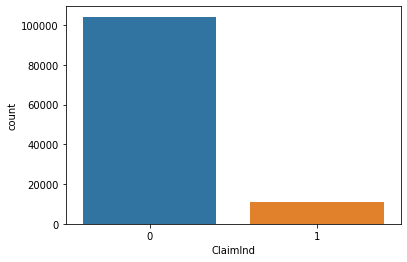

In [38]:
import seaborn as sns
sns.countplot(x=df.ClaimInd)

Классы целевой переменной не сбалансированы. Качество можно улучшить, если сбалансировать классы.

In [34]:
glm_balance = H2OGeneralizedLinearEstimator(family = "binomial", nfolds=5, balance_classes=True)
glm_balance.train(y="ClaimInd", x = h2o_train.names[1:-1], training_frame = h2o_train, validation_frame = h2o_valid)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [35]:
ac_train_pred = glm_balance.predict(h2o_train).as_data_frame()
ac_valid_pred = glm_balance.predict(h2o_valid).as_data_frame()
ac_test_pred = glm_balance.predict(h2o_test).as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


In [36]:
print(f'Accuracy score для обучающей выборки {accuracy_score(y_train_ind, train_pred.predict)}')
print(f'Accuracy score для валидационной выборки {accuracy_score(y_valid_ind, valid_pred.predict)}')
print(f'Accuracy score для тестовой выборки {accuracy_score(y_test_ind, test_pred.predict)}')

Accuracy score для обучающей выборки 0.5789623858674077
Accuracy score для валидационной выборки 0.5829329010594569
Accuracy score для тестовой выборки 0.5762996410790784


In [37]:
print(f'F1 score для обучающей выборки {f1_score(y_train_ind, train_pred.predict)}')
print(f'F1 score для валидационной выборки {f1_score(y_valid_ind, valid_pred.predict)}')
print(f'F1 score для тестовой выборки {f1_score(y_test_ind, test_pred.predict)}')

F1 score для обучающей выборки 0.1853923145236781
F1 score для валидационной выборки 0.18654019873532068
F1 score для тестовой выборки 0.1846942185585385


Почему-то изменений после внесения параметра "balance_classes=True" не увидел. Надо пробовать очистку данных или другие модели.